In [1]:
import os
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from download import download

import mindspore as ms
from mindspore import Tensor, nn, ops, save_checkpoint
from mindspore.common import dtype
import mindspore.dataset as ds

In [2]:
batch_size = 128    # 用于训练的训练集批量大小
total_epoch = 200   # 训练周期数
latent_size = 100   # 隐码z的长度
img_size = 28       # 训练图像长（宽）
lr = 0.0002         # 优化器（Adam）学习率
beta1 = 0.5         # 优化器（Adam）一阶动量衰减率
beta2 = 0.999       # 优化器（Adam）二阶动量衰减率

In [3]:
# 数据下载
download_url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/MNIST_Data.zip"
download(download_url, ".", kind="zip", replace=True)


file_sizes: 100%|██████████████████████████| 10.8M/10.8M [00:00<00:00, 23.2MB/s]
Extracting zip file...
Successfully downloaded / unzipped to .


'.'

In [4]:
# 读取数据，并将MNIST训练集和验证集合并为一个整体
train_dataset = ds.MnistDataset(dataset_dir='./MNIST_Data/train')
test_dataset = ds.MnistDataset(dataset_dir='./MNIST_Data/test')
mnist_ds = train_dataset.concat(test_dataset)

# 设置训练集的批量大小
mnist_ds = mnist_ds.batch(batch_size=batch_size, drop_remainder=True)

# 打印训练集批次总量
iter_size = mnist_ds.get_dataset_size()
print('Iter size: %d' % iter_size)

Iter size: 546


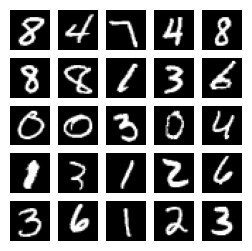

In [5]:
data_iter = next(mnist_ds.create_dict_iterator(output_numpy=True))
figure = plt.figure(figsize=(3, 3))
# 可视化5行5列共25个训练图像样本
cols, rows = 5, 5
for idx in range(cols * rows):
    image = data_iter['image'][idx]
    figure.add_subplot(rows, cols, idx + 1)
    plt.axis("off")
    plt.imshow(image.squeeze(), cmap="gray")
plt.show()

In [6]:
# 生成器模型构造
class Generator(nn.Cell):
    def __init__(self, latent_size, auto_prefix=True):
        super(Generator, self).__init__(auto_prefix=auto_prefix)
        self.model = nn.SequentialCell()
        # [N, 100] -> [N, 128]
        # 输入一个100维的0～1之间的高斯分布，然后通过第一层线性变换将其映射到256维
        self.model.append(nn.Dense(latent_size, 128))
        self.model.append(nn.ReLU())
        # [N, 128] -> [N, 256]
        self.model.append(nn.Dense(128, 256))
        self.model.append(nn.BatchNorm1d(256))
        self.model.append(nn.ReLU())
        # [N, 256] -> [N, 512]
        self.model.append(nn.Dense(256, 512))
        self.model.append(nn.BatchNorm1d(512))
        self.model.append(nn.ReLU())
        # [N, 512] -> [N, 1024]
        self.model.append(nn.Dense(512, 1024))
        self.model.append(nn.BatchNorm1d(1024))
        self.model.append(nn.ReLU())
        # [N, 1024] -> [N, 784]
        # 经过线性变换将其变成784维
        self.model.append(nn.Dense(1024, img_size * img_size))
        # 经过Tanh激活函数是希望生成的假的图片数据分布能够在-1～1之间
        self.model.append(nn.Tanh())

    def construct(self, noise):
        img = self.model(noise)
        return ops.reshape(img, (-1, 1, 28, 28))

# 创建生成器实例
# 注意实例化生成器之后需要修改参数的名称，否则静态图模式下会报错
net_g = Generator(latent_size)
net_g.update_parameters_name('generator')

In [7]:
# 判别器模型构造
class Discriminator(nn.Cell):
   def __init__(self, auto_prefix=True):
       super().__init__(auto_prefix=auto_prefix)
       self.model = nn.SequentialCell()
       # [N, 784] -> [N, 512]
       self.model.append(nn.Dense(img_size * img_size, 512))  # 输入特征数为784，输出为512
       self.model.append(nn.LeakyReLU())  # 默认斜率为0.2的非线性映射激活函数
       # [N, 512] -> [N, 256]
       self.model.append(nn.Dense(512, 256))  # 进行一个线性映射
       self.model.append(nn.LeakyReLU())
       # [N, 256] -> [N, 1]
       self.model.append(nn.Dense(256, 1))
       self.model.append(nn.Sigmoid())  # 二分类激活函数，将实数映射到[0,1]

   def construct(self, x):
       x_flat = ops.reshape(x, (-1, img_size * img_size))
       return self.model(x_flat)

# 创建判别器实例
net_d = Discriminator()
net_d.update_parameters_name('discriminator')

In [8]:
# 损失函数
adversarial_loss = nn.BCELoss(reduction='mean')

# 优化器
optimizer_d = nn.Adam(net_d.trainable_params(), learning_rate=lr, beta1=beta1, beta2=beta2)
optimizer_g = nn.Adam(net_g.trainable_params(), learning_rate=lr, beta1=beta1, beta2=beta2)
optimizer_g.update_parameters_name('optim_g')
optimizer_d.update_parameters_name('optim_d')

# 固定隐码
fixed_noise = Tensor(np.random.normal(size=(25, latent_size)), dtype.float32)

Epoch:[  0/200], step:[   0/ 546], loss_d:1.453682 , loss_g:0.727539 , time:11.761888s, lr:0.000200
Epoch:[  0/200], step:[  10/ 546], loss_d:1.118150 , loss_g:0.633681 , time:0.014076s, lr:0.000200
Epoch:[  0/200], step:[  20/ 546], loss_d:1.360800 , loss_g:0.622689 , time:0.014258s, lr:0.000200
Epoch:[  0/200], step:[  30/ 546], loss_d:1.316303 , loss_g:0.736686 , time:0.013849s, lr:0.000200
Epoch:[  0/200], step:[  40/ 546], loss_d:1.346644 , loss_g:0.794893 , time:0.014109s, lr:0.000200
Epoch:[  0/200], step:[  50/ 546], loss_d:1.361206 , loss_g:0.844561 , time:0.016356s, lr:0.000200
Epoch:[  0/200], step:[  60/ 546], loss_d:1.322595 , loss_g:0.961643 , time:0.016932s, lr:0.000200
Epoch:[  0/200], step:[  70/ 546], loss_d:1.154682 , loss_g:1.190741 , time:0.017507s, lr:0.000200
Epoch:[  0/200], step:[  80/ 546], loss_d:1.259218 , loss_g:1.145293 , time:0.017130s, lr:0.000200
Epoch:[  0/200], step:[  90/ 546], loss_d:1.105301 , loss_g:1.309783 , time:0.016350s, lr:0.000200
Epoch:[  

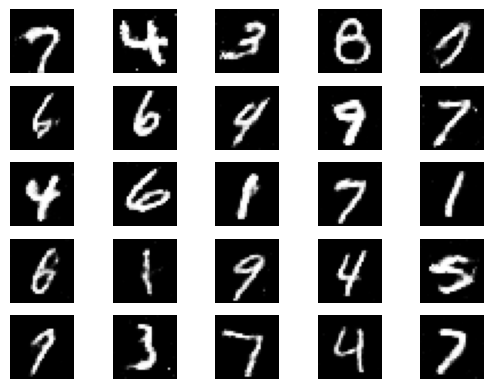

In [9]:
checkpoints_path = "./result/checkpoints"  # 结果保存路径
image_path = "./result/images"  # 测试结果保存路径

# 生成器计算损失过程
def generator_forward(test_noises):
    fake_data = net_g(test_noises)
    fake_out = net_d(fake_data)
    loss_g = adversarial_loss(fake_out, ops.ones_like(fake_out))
    return loss_g

# 判别器计算损失过程
def discriminator_forward(real_data, test_noises):
    # 全伪批次的损失
    fake_data = net_g(test_noises)
    fake_out = net_d(fake_data)
    fake_loss = adversarial_loss(fake_out, ops.zeros_like(fake_out))
    # 全真批次的损失
    real_out = net_d(real_data)
    real_loss = adversarial_loss(real_out, ops.ones_like(real_out))
    # 总损失
    loss_d = real_loss + fake_loss
    return loss_d

# 梯度方法
grad_g = ms.value_and_grad(generator_forward, None, net_g.trainable_params())
grad_d = ms.value_and_grad(discriminator_forward, None, net_d.trainable_params())

# 模型训练
def train_step(real_data, latent_code):
    # 计算判别器的损失和梯度，并优化判别器
    loss_d, grads_d = grad_d(real_data, latent_code)
    optimizer_d(grads_d)
    
    # 计算生成器的损失和梯度，并优化生成器
    loss_g, grads_g = grad_g(latent_code)
    optimizer_g(grads_g)

    return loss_d, loss_g

# 保存生成的test图像
def save_imgs(gen_imgs, idx):
    for i in range(gen_imgs.shape[0]):
        plt.subplot(5, 5, i + 1)
        plt.imshow(gen_imgs[i, 0, :, :], cmap="gray")
        plt.axis("off")
    plt.savefig(image_path + "/test_{}.png".format(idx))

# 设置参数保存路径
os.makedirs(checkpoints_path, exist_ok=True)
# 设置中间过程生成图片保存路径
os.makedirs(image_path, exist_ok=True)

# 储存生成器和判别器loss
losses_g, losses_d = [], []

# 模型训练
for epoch in range(total_epoch):
    start = time.time()
    net_g.set_train(True)
    net_d.set_train(True)
    for (iter, (image, _)) in enumerate(mnist_ds.create_tuple_iterator()):
        start1 = time.time()

        image = (image - 127.5) / 127.5  # [0, 255] -> [-1, 1]
        image = image.transpose(0, 3, 1, 2) # NHWC -> NCHW

        latent_code = np.random.normal(size=(image.shape[0], latent_size))
        latent_code = Tensor(latent_code, dtype.float32)

        d_loss, g_loss = train_step(image, latent_code)
        end1 = time.time()
        if iter % 10 == 0:
            print(f"Epoch:[{int(epoch):>3d}/{int(total_epoch):>3d}], "
                  f"step:[{int(iter):>4d}/{int(iter_size):>4d}], "
                  f"loss_d:{d_loss.asnumpy():>4f} , "
                  f"loss_g:{g_loss.asnumpy():>4f} , "
                  f"time:{(end1 - start1):>3f}s, "
                  f"lr:{lr:>6f}")

    end = time.time()
    print("time of epoch {} is {:.2f}s".format(epoch + 1, end - start))

    losses_d.append(d_loss.asnumpy())
    losses_g.append(g_loss.asnumpy())

    # 每个epoch结束后，使用生成器生成一组图片
    net_g.set_train(False)
    gen_imgs = net_g(fixed_noise)
    save_imgs(gen_imgs.asnumpy(), epoch)

    # 根据epoch保存模型权重文件
    if epoch % 1 == 0:
        save_checkpoint(net_g, checkpoints_path + "/Generator%d.ckpt" % (epoch))
        save_checkpoint(net_d, checkpoints_path + "/Discriminator%d.ckpt" % (epoch))

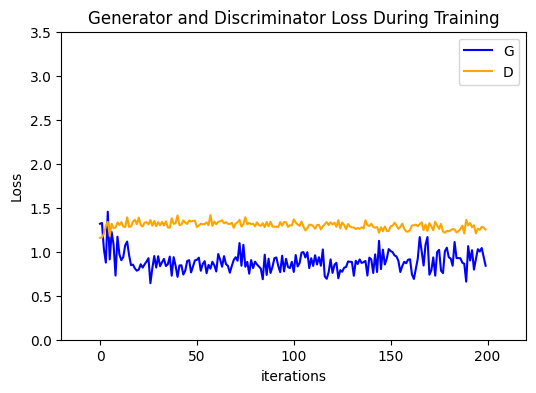

In [10]:
plt.figure(figsize=(6, 4))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(losses_g, label="G", color='blue')
plt.plot(losses_d, label="D", color='orange')
plt.xlim(-20, 220)
plt.ylim(0, 3.5)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

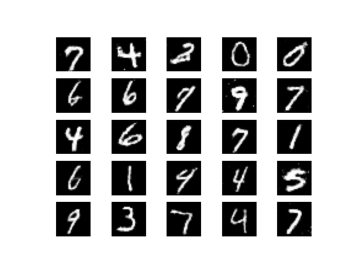

In [11]:
# 生成图片变化.gif
image_list = []
for i in range(total_epoch):
    image_list.append(cv2.imread(image_path + "/test_{}.png".format(i), cv2.IMREAD_GRAYSCALE))
show_list = []
fig = plt.figure(dpi=70)
for epoch in range(0, len(image_list), 5):
    plt.axis("off")
    show_list.append([plt.imshow(image_list[epoch], cmap='gray')])

ani = animation.ArtistAnimation(fig, show_list, interval=1000, repeat_delay=1000, blit=True)
ani.save('train_test.gif', writer='pillow', fps=3)

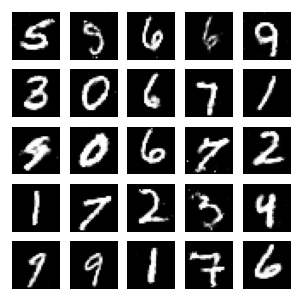

In [12]:
# 加载训练结果并展示生成图片
# 加载训练结果
test_ckpt = './result/checkpoints/Generator199.ckpt'
parameter = ms.load_checkpoint(test_ckpt)
ms.load_param_into_net(net_g, parameter)
# 模型生成结果
test_data = Tensor(np.random.normal(0, 1, (25, 100)).astype(np.float32))
images = net_g(test_data).transpose(0, 2, 3, 1).asnumpy()
# 结果展示
fig = plt.figure(figsize=(3, 3), dpi=120)
for i in range(25):
    fig.add_subplot(5, 5, i + 1)
    plt.axis("off")
    plt.imshow(images[i].squeeze(), cmap="gray")
plt.show()